# Check GPU

In [1]:
import torch

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

GPU Available: True
GPU Name: NVIDIA H100


# Load datasets

In [ ]:
from datasets import load_dataset
import os

data_path = "../data/newsela_article_corpus_2016-01-29/datasets"

data_files_from_sent = {
    'train': os.path.join(data_path,"train_from_sent.csv"),      
    'validation': os.path.join(data_path,"valid_from_sent.csv"),  
    'test': os.path.join(data_path,"test_from_sent.csv")         
}

dataset = load_dataset('csv', data_files=data_files_from_sent)
print(dataset)

## Check texts length

In [7]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=512):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            num_words = len(example[column].split())  # Counting words by splitting on spaces
            if num_words > word_limit:
                count_over_limit += 1

        word_count[split] = count_over_limit

    return word_count

In [15]:
print("Model's max length: ", tokenizer.model_max_length)

Model's max length:  1024


In [12]:
count_texts_over_word_limit(dataset, column='r_content', word_limit=1024)

{'train': 460, 'validation': 47, 'test': 60}

In [11]:
count_texts_over_word_limit(dataset, column='s_content', word_limit=1024)

{'train': 15, 'validation': 1, 'test': 1}

# Load the model

In [2]:
from transformers import BartTokenizerFast, BartForConditionalGeneration 
import torch

tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-large') 
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

## Tokenize datasets

In [3]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['r_content'], truncation=True, padding="max_length", max_length=1024)
    # labels
    labels = tokenizer(examples['s_content'],truncation=True, padding="max_length", max_length=1024)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

In [4]:
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Set up model's configuration

## Generation config

In [5]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    bos_token_id = 0,
    decoder_start_token_id = 2,
    early_stopping = True,
    eos_token_id = 2, 
    forced_bos_token_id = 0,
    forced_eos_token_id = 2,
    no_repeat_ngram_size = 3,
    num_beams = 4,
    pad_token_id = 1
)

model.config.update(generation_config.to_dict())

## Dropout

In [6]:
model.config.dropout = 0.2
print(model.config.dropout)

0.2


## Tokenizer

In [ ]:
from transformers import AddedToken

special_tokens_dict = {
    'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)
}

# add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

# Train the model

In [6]:
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
num_samples = len(dataset['train'])
batch_size= 6
logging_steps = 25
print("Steps per epoch: ", num_samples//batch_size )
print("Logging steps: " ,num_samples//batch_size//logging_steps )

Steps per epoch:  150
Logging steps:  6


## Seq2Seq

In [7]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
from easse.sari import corpus_sari

def compute_sari(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # source texts 
    sources = tokenized_dataset['validation']['r_content']

    # SARI scores
    sari_scores = []
    for pred, label, source in zip(decoded_preds, decoded_labels, sources):
        sari_score = corpus_sari(
            orig_sents=[source],  # original source sentence
            sys_sents=[pred],     # system's generated sentence
            refs_sents=[[label]]  # reference simplified sentence
        )
        sari_scores.append(sari_score)
    
    # average SARI score across all examples
    avg_sari = np.mean(sari_scores)
    return {"sari": avg_sari}

model.train()

training_args = Seq2SeqTrainingArguments(
    output_dir="../models/bart-news-ft/results/results-news-bart-epoch10-lr1-wd0.1",
    eval_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="steps",
    logging_steps=25,
    learning_rate=1e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6, 
    num_train_epochs=10,
    save_total_limit=3,
    weight_decay=0.1,
    warmup_steps = 2,
    #gradient_accumulation_steps=2,
    optim = "paged_adamw_8bit",
    load_best_model_at_end=True,
    fp16=True,
    logging_dir="../models/bart-news-ft/logs/logs-news-bart-epoch10-lr1-wd0.1",
    predict_with_generate=True,
    metric_for_best_model='loss'
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_sari,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

## Trainer

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from easse.sari import corpus_sari
from tqdm.notebook import tqdm

def compute_sari(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # source texts 
    sources = tokenized_dataset['validation']['r_content']

    # SARI scores
    sari_scores = []
    for pred, label, source in tqdm(zip(decoded_preds, decoded_labels, sources)):
        sari_score = corpus_sari(
            orig_sents=[source],  # original source sentence
            sys_sents=[pred],     # system's generated sentence
            refs_sents=[[label]]  # reference simplified sentence
        )
        sari_scores.append(sari_score)
    
    # average SARI score across all examples
    avg_sari = np.mean(sari_scores)
    return {"sari": avg_sari}

model.train()

training_args = TrainingArguments(
    output_dir="../models/bart-news-ft/results/results-news-bart-epoch10-lr1-trainer",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=25,
    learning_rate=1e-5, 
    per_device_train_batch_size=6, 
    per_device_eval_batch_size=6, 
    num_train_epochs=10, 
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    metric_for_best_model='loss',
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir="../models/bart-news-ft/logs/logs-news-bart-epoch10-lr1-trainer",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_sari,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

In [ ]:
trainer.train()

## Training Process

In [13]:
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if "eval_loss" in log]

# the best (lowest) validation loss
best_eval_log = min(eval_logs, key=lambda x: x["eval_loss"])

print(f"Best validation loss: {best_eval_log['eval_loss']}")
print(f"Epoch of the best model: {best_eval_log['epoch']}")
#print("Sari score: ", best_eval_log['eval_sari'] )

Best validation loss: 1.0949653387069702
Epoch of the best model: 8.0


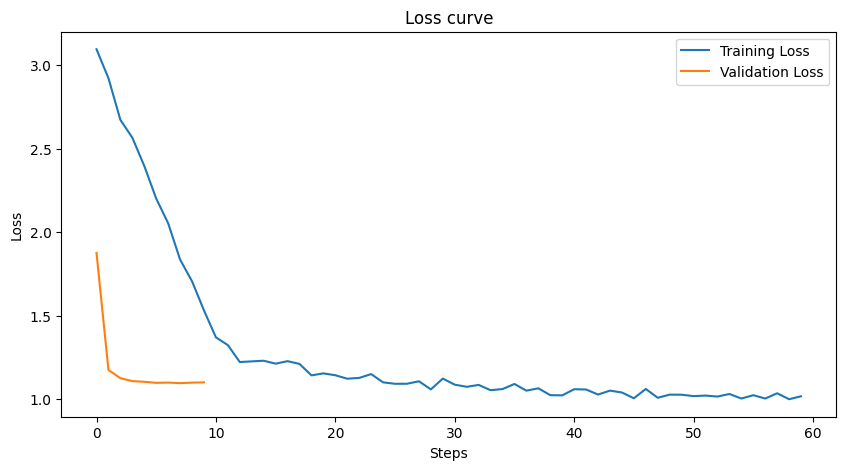

In [14]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Generate predictions

In [15]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

## Sample

In [22]:
torch.cuda.empty_cache()

In [23]:
example = dataset['validation'][0]
#print(f"Original text: {example['r_content'][:500]}", end="\n\n")

model.eval()
model.config.use_cache = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # torch.cuda.current_device() 
model.to(device)

print(f"Device: {device}")
print(f"Model device: {next(model.parameters()).device}", end="\n\n" )

print(f"Model vocab size: {model.config.vocab_size}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}", end="\n\n")

try:

    input_ids = tokenizer(example['r_content'], return_tensors="pt", truncation=True, max_length=1024)  
    
    # input_ids info
    #print("Input IDs before device transfer:")
    #for key, value in input_ids.items():
        #print(f"{key}: {value.shape}, dtype: {value.dtype}", end="\n\n")

    # out-of-vocabulary tokens
    #vocab_size = tokenizer.vocab_size
    #input_id_values = input_ids['input_ids'][0].tolist()
    #print(f"First 10 token IDs: {input_id_values[:10]}")
    #print(f"Last 10 token IDs: {input_id_values[-10:]}")

    # move input_ids to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}

    # generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            **input_ids, 
            max_length=512  
        )

    # decode generated output
    simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    print(f"Simplified (highlighted): ")
    display(HTML(highlight_diff(example['r_content'], simplified_text)))

except Exception as e:
    print(f"Error during generation: {e}")

Device: cuda:0
Model device: cuda:0

Model vocab size: 50265
Tokenizer vocab size: 50265

Simplified (highlighted): 


## SARI score for test dataset

In [15]:
from tqdm import tqdm
import torch

predictions = []

model.eval()
model.config.use_cache = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for example in tqdm(dataset['validation']):
        # tokenize the text
        input_ids = tokenizer(example['r_content'], return_tensors="pt",truncation=True, max_length=1024)
        # move input_ids to the same device as the model
        input_ids = {key: value.to(device) for key, value in input_ids.items()}
        
        # generate prediction
        output_ids = model.generate(**input_ids, max_length=1024, temperature=1.5, num_beams=4, num_return_sequences=1, do_sample=True) 
        simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        predictions.append(simplified_text)

100%|█████████████████████████████████████████| 113/113 [15:28<00:00,  8.22s/it]


In [16]:
from tqdm.notebook import tqdm
from easse.sari import corpus_sari


sari_scores_easse = []

for index, row in tqdm(enumerate(dataset["validation"]), total=len(dataset["validation"])):
    r_content = row['r_content'] 
    s_content = row['s_content']
    prediction = predictions[index] 
    
    sari_score_easse = corpus_sari(
        orig_sents=[r_content],
        sys_sents=[prediction],
        refs_sents=[[s_content]]
    )
    
    sari_scores_easse.append(sari_score_easse)

  0%|          | 0/113 [00:00<?, ?it/s]

In [17]:
import numpy as np
print("Mean SARI score:", np.mean(sari_scores_easse))

Mean SARI score: 40.60537050755908
